**Training Megadetector on the COD10K Dataset**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Project

/content/drive/.shortcut-targets-by-id/1taf0FzaTigDj81T0xX-2Zzj1-KAeXxpg/dataset


Cloning the CameraTraps Repository

In [ ]:
!git clone https://github.com/microsoft/CameraTraps.git

Cloning into 'CameraTraps'...
remote: Enumerating objects: 19526, done.
remote: Counting objects: 100% (342/342), done.
remote: Compressing objects: 100% (220/220), done.
remote: Total 19526 (delta 137), reused 131 (delta 122), pack-reused 19184 (from 4)
Receiving objects: 100% (19526/19526), 496.77 MiB | 16.60 MiB/s, done.
Resolving deltas: 100% (10190/10190), done.
Updating files: 100% (166/166), done.


In [ ]:
%cd CameraTraps/PW_FT_detection

/content/drive/.shortcut-targets-by-id/1taf0FzaTigDj81T0xX-2Zzj1-KAeXxpg/dataset/CameraTraps/PW_FT_detection


Dataset Preparation: Get it into a format that the megadetector wants

In [3]:
import os, shutil, json
from PIL import Image

BASE = '/content/drive/MyDrive/Project/cod10k/COD10K-v3'


TRAIN_JSON = os.path.join(BASE, 'Train/CAM_Instance_Train.json')
TEST_JSON  = os.path.join(BASE, 'Test/CAM_Instance_Test.json')
TRAIN_IMG  = os.path.join(BASE, 'Train/Image')
TEST_IMG   = os.path.join(BASE, 'Test/Image')

DATASET_ROOT = '/content/drive/MyDrive/dataset/CameraTraps/PW_FT_detection/data/COD10K'
for sub in ('images/train','labels/train','images/test','labels/test'):
    os.makedirs(os.path.join(DATASET_ROOT, sub), exist_ok=True)


In [ ]:
!ls /content/drive/MyDrive/dataset/cod10k/COD10K-v3/Train

CAM_Instance_Train.json        GT_Edge	    GT_Object
CAM-NonCAM_Instance_Train.txt  GT_Instance  Image


Making Labels files in YOLO Format out of the COD10K annotations

In [ ]:
# 1) Copy all training .jpgs
for fn in os.listdir(TRAIN_IMG):
    if fn.lower().endswith('.jpg'):
        shutil.copy(os.path.join(TRAIN_IMG,fn),
                    os.path.join(DATASET_ROOT,'images/train',fn))

# 2) Load COCO JSON
with open(TRAIN_JSON) as f:
    coco = json.load(f)

# 3) Build lookup and group bboxes
img_meta  = {img['id']:(img['file_name'],img['width'],img['height']) for img in coco['images']}
ann_by_id = {}
for ann in coco['annotations']:
    ann_by_id.setdefault(ann['image_id'],[]).append(ann['bbox'])

# 4) Write YOLO .txt labels
for img_id, bbs in ann_by_id.items():
    fn, W, H = img_meta[img_id]
    lines = []
    # Determine class (1 for Human, 0 otherwise)
    class_id = 1 if 'Human' in fn else 0
    for x,y,w,h in bbs:
        xc = (x + w/2)/W; yc = (y + h/2)/H
        wn = w/W;      hn = h/H
        lines.append(f"{class_id} {xc:.6f} {yc:.6f} {wn:.6f} {hn:.6f}")
    out = os.path.join(DATASET_ROOT,'labels/train',fn.replace('.jpg','.txt'))
    with open(out,'w') as f: f.write("\n".join(lines))

In [ ]:
# 1) Copy all test .jpgs
for fn in os.listdir(TEST_IMG):
    if fn.lower().endswith('.jpg'):
        shutil.copy(os.path.join(TEST_IMG,fn),
                    os.path.join(DATASET_ROOT,'images/test',fn))

# 2) Load COCO JSON
with open(TEST_JSON) as f:
    coco = json.load(f)

# 3) Build lookup
img_meta  = {img['id']:(img['file_name'],img['width'],img['height']) for img in coco['images']}
ann_by_id = {}
for ann in coco['annotations']:
    ann_by_id.setdefault(ann['image_id'],[]).append(ann['bbox'])

# 4) Write YOLO .txt labels
for img_id, bbs in ann_by_id.items():
    fn, W, H = img_meta[img_id]
    lines = []
    class_id = 1 if 'Human' in fn else 0
    for x,y,w,h in bbs:
        xc = (x + w/2)/W; yc = (y + h/2)/H
        wn = w/W;      hn = h/H
        lines.append(f"{class_id} {xc:.6f} {yc:.6f} {wn:.6f} {hn:.6f}")
    out = os.path.join(DATASET_ROOT,'labels/test',fn.replace('.jpg','.txt'))
    with open(out,'w') as f: f.write("\n".join(lines))


Empty labels for NonCAM Images

In [ ]:
def process_images(image_dir, json_path, output_img_dir, output_label_dir):
    for fn in os.listdir(image_dir):
        if fn.lower().endswith('.jpg')  and 'NonCAM' in fn:
            shutil.copy(os.path.join(image_dir, fn),
                      os.path.join(output_img_dir, fn))
            # Create empty label file
            out = os.path.join(output_label_dir, fn.replace('.jpg','.txt'))
            open(out, 'w').close()
            print(f"Created empty label for NonCAM image: {fn}")

print("Processing training data...")
process_images(TRAIN_IMG, TRAIN_JSON,
              os.path.join(DATASET_ROOT, 'images/train'),
              os.path.join(DATASET_ROOT, 'labels/train'))

print("\nProcessing test data...")
process_images(TEST_IMG, TEST_JSON,
              os.path.join(DATASET_ROOT, 'images/test'),
              os.path.join(DATASET_ROOT, 'labels/test'))

Processing training data...
Created empty label for NonCAM image: COD10K-NonCAM-4-Terrestial-2678.jpg
Created empty label for NonCAM image: COD10K-NonCAM-5-Background-2-Ocean-3405.jpg
Created empty label for NonCAM image: COD10K-NonCAM-5-Background-4-Sky-4291.jpg
Created empty label for NonCAM image: COD10K-NonCAM-5-Background-2-Ocean-3156.jpg
Created empty label for NonCAM image: COD10K-NonCAM-5-Background-3-Sand-3956.jpg
Created empty label for NonCAM image: COD10K-NonCAM-5-Background-1-Indoor-3102.jpg
Created empty label for NonCAM image: COD10K-NonCAM-5-Background-3-Sand-4031.jpg
Created empty label for NonCAM image: COD10K-NonCAM-5-Background-2-Ocean-3556.jpg
Created empty label for NonCAM image: COD10K-NonCAM-5-Background-4-Sky-4274.jpg
Created empty label for NonCAM image: COD10K-NonCAM-5-Background-2-Ocean-3503.jpg
Created empty label for NonCAM image: COD10K-NonCAM-5-Background-2-Ocean-3469.jpg
Created empty label for NonCAM image: COD10K-NonCAM-4-Terrestial-2773.jpg
Created e

Just checking if the labels file we made exist

In [4]:
lbl_path = os.path.join(DATASET_ROOT, 'labels/test','COD10K-NonCAM-2-Aquatic-334.txt')
if os.path.exists(lbl_path):
  print("EXISTS!!")

else:
  print("Nope!")

EXISTS!!


In [19]:
%cd /content/drive/MyDrive/Project_Rayed/CameraTraps/PW_FT_detection
!pip install -r requirements.txt


/content/drive/MyDrive/Project_Rayed/CameraTraps/PW_FT_detection
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.1/72.1 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for PytorchWildlife: filename=PytorchWildlife-1.2.2-py3-none-any.whl size=70645 sha256=6377ac019be1fda8f3af77e379bd2988ffe05d9fc0be027e23e21d5c208939cb
  Stored in directory: /root/.cache/pip/wheels/27/bd/30/9f83541caffd157817027622a1937fbfa8f65ac6b803d31230
Successfully built PytorchWildlife


In [ ]:
NEW_FOLDER = '/content/drive/MyDrive/Project_Rayed'
os.makedirs(NEW_FOLDER, exist_ok=True)
!cp -r "/content/drive/MyDrive/Project/CameraTraps" "{NEW_FOLDER}"

Loading the pretrained weights

In [9]:
import sys
sys.path.insert(0, '/content/drive/MyDrive/Project_Rayed/CameraTraps/PW_FT_detection')
from utils import get_model_path
model_path = get_model_path("MDV6-yolov9-e")


In [20]:
import os
print("Current working directory:", os.getcwd())
!ls -l  # List files to verify config.yaml exists

Current working directory: /content/drive/MyDrive/Project_Rayed/CameraTraps/PW_FT_detection
total 25824
-rw------- 1 root root      521 Apr 30 06:33 config.yaml
drwx------ 4 root root     4096 Apr 30 14:10 data
-rw------- 1 root root     4322 Apr 30 06:33 environment.yaml
-rw------- 1 root root     2219 Apr 30 06:33 main.py
-rw------- 1 root root 20799488 Apr 30 06:33 MDV6-yolov9e.ptj5thvpjz.tmp
drwx------ 2 root root     4096 Apr 30 14:00 __pycache__
-rw------- 1 root root     7015 Apr 30 06:33 README.md
-rw------- 1 root root       38 Apr 30 14:23 requirements.txt
drwx------ 2 root root     4096 Apr 30 06:30 runs
-rw------- 1 root root     1412 Apr 30 06:33 utils.py
-rw------- 1 root root  5613764 Apr 30 06:33 yolo11n.pt


In [21]:
from munch import Munch
import yaml

with open("./config.yaml") as f:
        cfg = Munch(yaml.load(f, Loader=yaml.FullLoader))
cfg.weights = model_path

with open("config.yaml", "w") as f:
    yaml.dump(dict(cfg), f)

In [10]:
%%bash
cat > /content/drive/MyDrive/Project_Rayed/CameraTraps/PW_FT_detection/data/COD10K.yaml <<EOF
path: ../data/COD10K
train: images/train
val:   images/test
test:  images/test
names:
  0: animal
  1: person
EOF

echo "Wrote data/COD10K.yaml:"
cat /content/drive/MyDrive/Project_Rayed/CameraTraps/PW_FT_detection/data/COD10K.yaml


Wrote data/COD10K.yaml:
path: ../data/COD10K
train: images/train
val:   images/test
test:  images/test
names:
  0: animal
  1: person


Making the validation folders

In [22]:
import os
import random
import shutil

# Set your paths (modify these as needed)
data_root = '/content/drive/MyDrive/Project_Rayed/CameraTraps/PW_FT_detection/data/COD10K'
train_img_dir = os.path.join(data_root, 'images/train')
train_label_dir = os.path.join(data_root, 'labels/train')

# Create validation directories
val_img_dir = os.path.join(data_root, 'images/val')
val_label_dir = os.path.join(data_root, 'labels/val')
os.makedirs(val_img_dir, exist_ok=True)
os.makedirs(val_label_dir, exist_ok=True)

# Get all image files (assuming .jpg format)
image_files = [f for f in os.listdir(train_img_dir) if f.endswith('.jpg')]
random.shuffle(image_files)  # Shuffle randomly

# Calculate split index (90:10 ratio)
split_idx = int(0.9 * len(image_files))
train_files = image_files[:split_idx]
val_files = image_files[split_idx:]

# Move validation files to their new directories
for img_file in val_files:
    # Move image
    src_img = os.path.join(train_img_dir, img_file)
    dst_img = os.path.join(val_img_dir, img_file)
    shutil.move(src_img, dst_img)

    # Move corresponding label file
    label_file = img_file.replace('.jpg', '.txt')
    src_label = os.path.join(train_label_dir, label_file)
    dst_label = os.path.join(val_label_dir, label_file)
    if os.path.exists(src_label):  # Check if label exists
        shutil.move(src_label, dst_label)

print(f"Split complete: {len(train_files)} train, {len(val_files)} validation")
print(f"Validation images moved to: {val_img_dir}")
print(f"Validation labels moved to: {val_label_dir}")

Split complete: 5400 train, 600 validation
Validation images moved to: /content/drive/MyDrive/Project_Rayed/CameraTraps/PW_FT_detection/data/COD10K/images/val
Validation labels moved to: /content/drive/MyDrive/Project_Rayed/CameraTraps/PW_FT_detection/data/COD10K/labels/val


First approach to loading weights(run inference and the weights load automatically)

In [ ]:
#this one is to run it first so we get the weights
%cd /content/drive/MyDrive/dataset/CameraTraps/PW_FT_detection
!python main.py --task validation --config config.yaml

/content/drive/MyDrive/dataset/CameraTraps/PW_FT_detection
YOLOv9e summary: 721 layers, 58,147,225 parameters, 0 gradients, 192.7 GFLOPs
Ultralytics 8.3.119 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv9e summary (fused): 279 layers, 57,378,713 parameters, 0 gradients, 189.1 GFLOPs
val: Fast image access ✅ (ping: 0.6±0.2 ms, read: 0.1±0.0 MB/s, size: 92.0 KB)
val: Scanning /content/drive/MyDrive/dataset/CameraTraps/PW_FT_detection/data/data_example/labels/train... 10 images, 0 backgrounds, 0 corrupt: 100% 10/10 [00:13<00:00,  1.34s/it]
val: New cache created: /content/drive/MyDrive/dataset/CameraTraps/PW_FT_detection/data/data_example/labels/train.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 1/1 [00:00<00:00,  1.04it/s]
                   all         10         10      0.993          1      0.995      0.754
                animal         10         10      0.993          1      0.995      0.754
Speed: 0.7ms 

this is my config.yaml for the run above:
# General
model: YOLO #YOLO or RTDETR
model_name: MDV6-yolov9-e
data: /content/drive/MyDrive/dataset/CameraTraps/PW_FT_detection/data/data_example.yaml
test_data: /content/drive/MyDrive/dataset/CameraTraps/PW_FT_detection/data/data_example/images/val
task: validation
exp_name: MDV6-yolov9-e

# Train
epochs: 20
batch_size_train: 16
imgsz: 640
device_train: 0
workers: 8
optimizer: auto
lr0: 0.01
patience: 5
save_period: 1
val: True
resume: False
weights: None # Path to weight to resume training

# Validation
save_json: True
plots: True
device_val: 0
batch_size_val: 12

and my data_example.yaml:
names:
  0: animal
  1: person
  2: vehicle
path: /content/drive/MyDrive/dataset/CameraTraps/PW_FT_detection/data/data_example
test: images/val
train: images/train
val:   images/val

More Training Prep

In [ ]:
# === General ===
model: YOLO
model_name: MDV6-yolov9-c
data: ./data/COD10K.yaml
task: train
exp_name: COD10K_finetune

# === Training ===
epochs: 20
batch_size_train: 16
imgsz: 640
device_train: 0
workers: 8
optimizer: auto
lr0: 0.01
patience: 5       # <-- already present
save_period: 1    # <-- make sure this line is here
val: True
resume: False
weights: None

# === Validation (during training) ===
save_json: True
plot: True
device_val: 0
batch_size_val: 12

current config for all the stuf going on

SyntaxError: invalid syntax (<ipython-input-10-70dca45d6676>, line 5)

In [24]:
%cd /content/drive/MyDrive/Project_Rayed/CameraTraps/PW_FT_detection

/content/drive/MyDrive/Project_Rayed/CameraTraps/PW_FT_detection
Traceback (most recent call last):
  File "/content/drive/MyDrive/Project_Rayed/CameraTraps/PW_FT_detection/main.py", line 79, in <module>
    main()
  File "/content/drive/MyDrive/Project_Rayed/CameraTraps/PW_FT_detection/main.py", line 25, in main
    with open(cfg.data) as f:
         ^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/dataset/CameraTraps/PW_FT_detection/data/COD10K.yaml'


In [ ]:
!python main.py

YOLOv9c summary: 358 layers, 25,531,545 parameters, 0 gradients, 103.7 GFLOPs
Ultralytics 8.3.121 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/root/.cache/torch/hub/checkpoints/MDV6b-yolov9c.pt, data=/content/drive/MyDrive/Project_Rayed/CameraTraps/PW_FT_detection/data/COD10K.yaml, epochs=20, time=None, patience=5, batch=16, imgsz=640, save=True, save_period=1, cache=False, device=0, workers=8, project=runs/train_COD10K_finetune, name=exp3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, 

We've trained this for 8 epochs so far and the t4 memory ran out, we'll be continuing with the same approach moving forward, with the goal of not just detecting but classifying as well.

The image displayed by the following cell is our progress so far

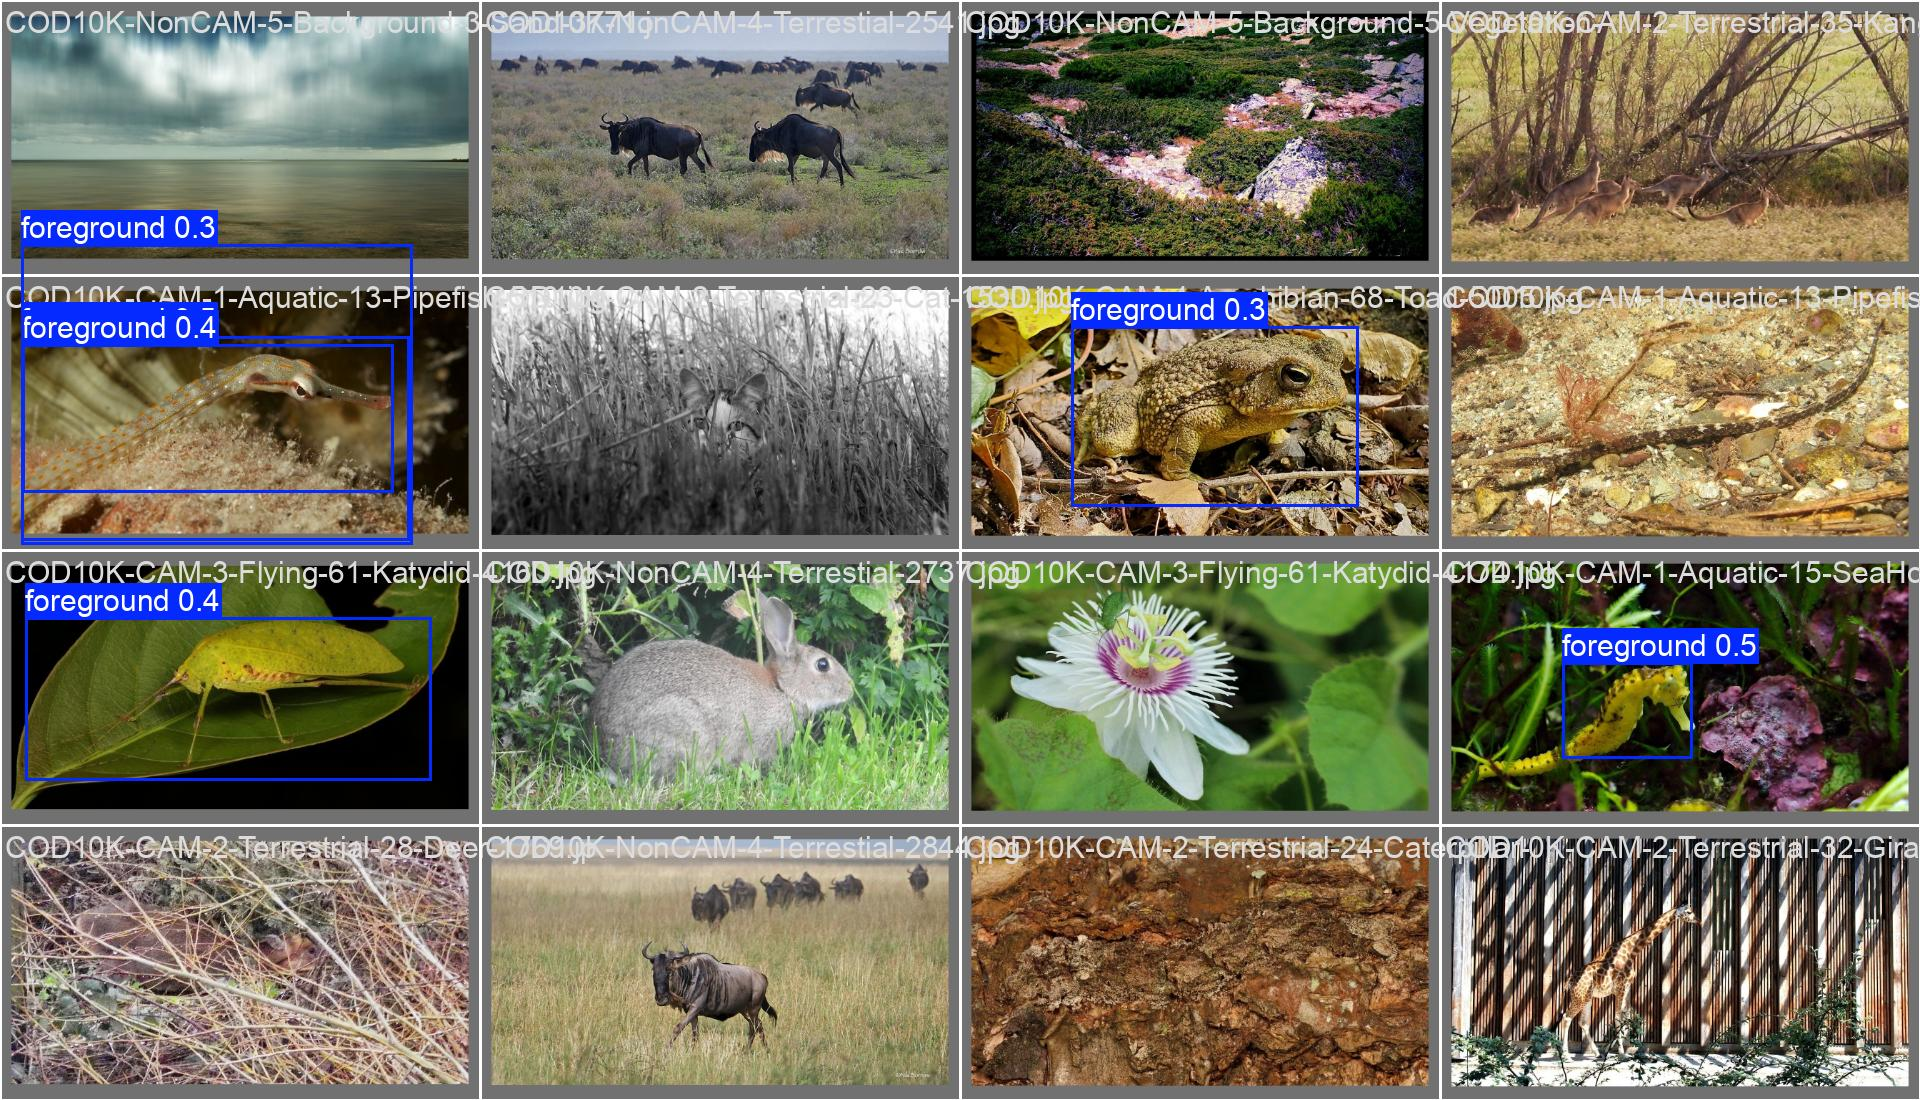

In [2]:
from IPython.display import Image, display

image_path = "/content/drive/MyDrive/Project_Rayed/CameraTraps/PW_FT_detection/runs/train_COD10K_finetune/exp2/val_batch2_pred.jpg"
display(Image(filename=image_path, width=600))

The image displayed by the follwing cell is our goal(with detection only, we aim to classify further as well)

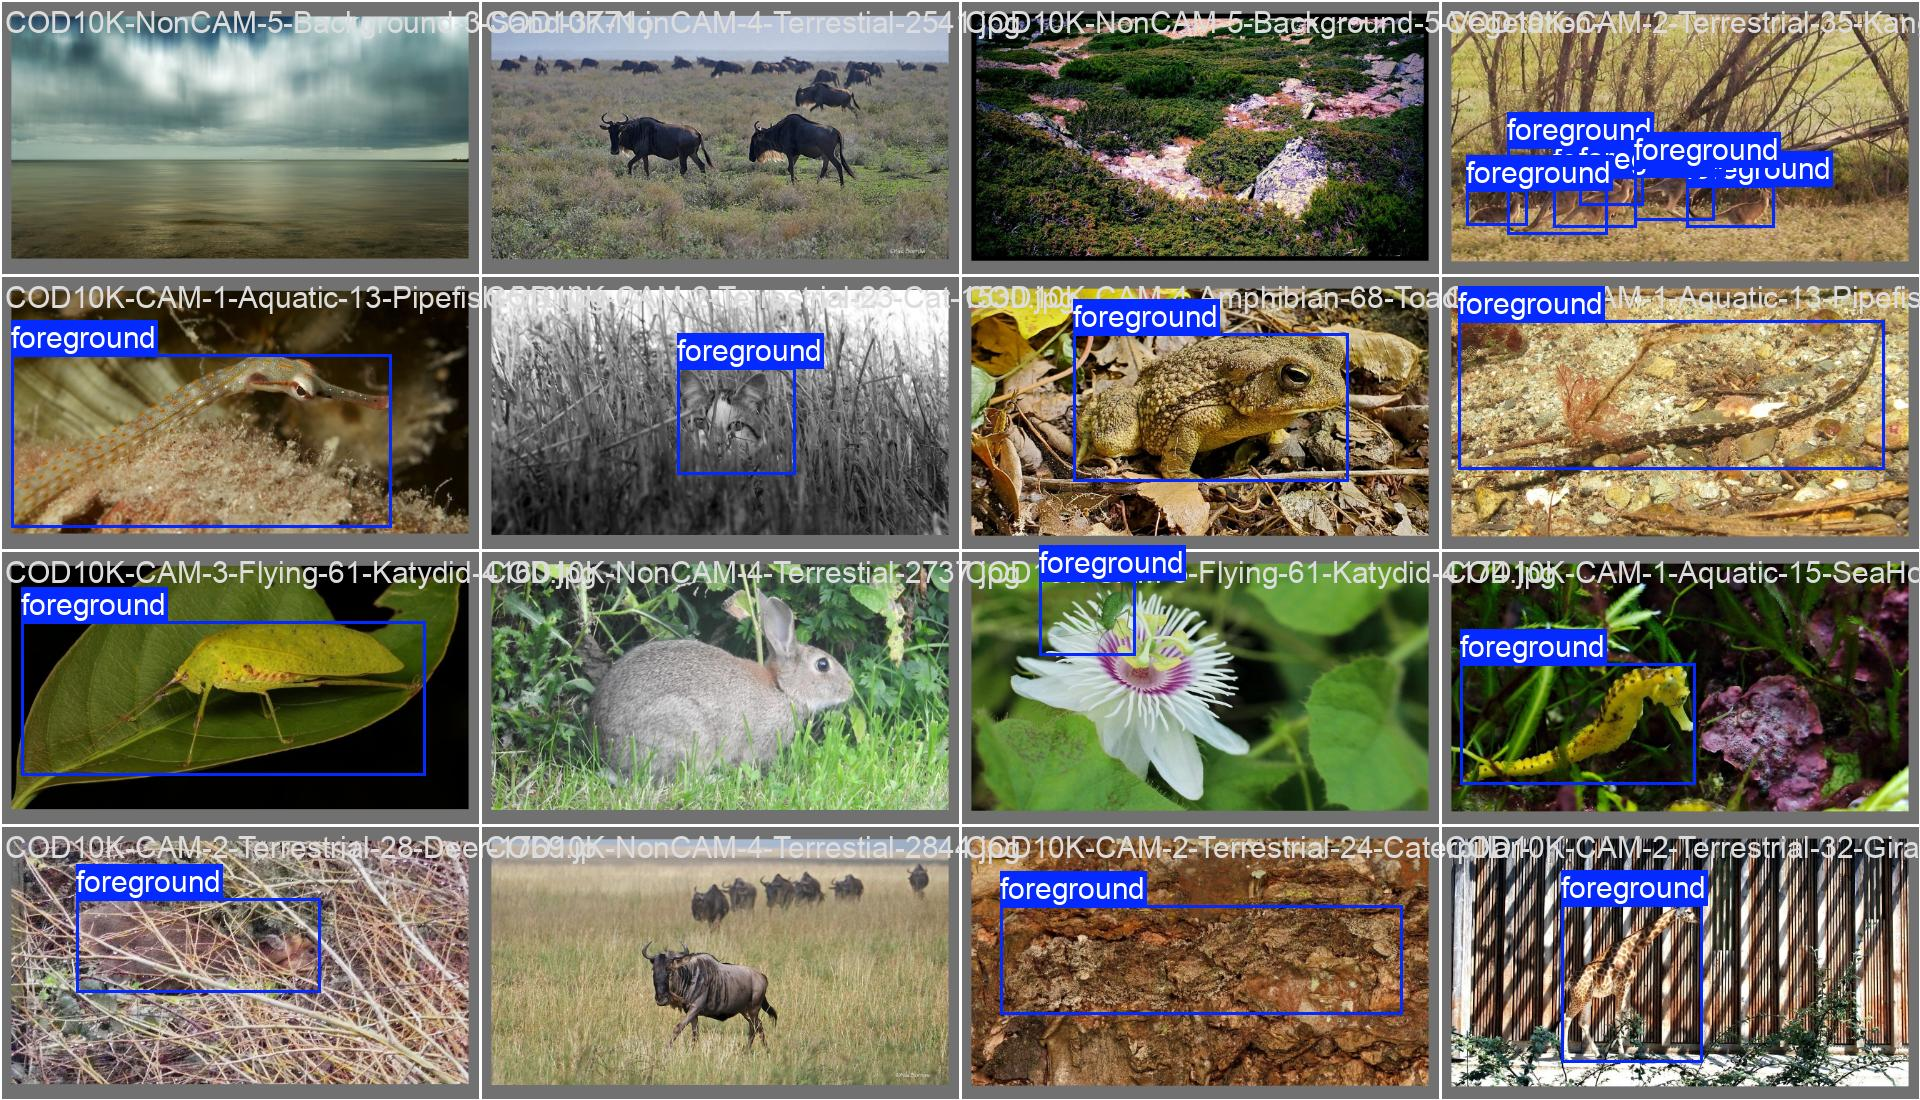

In [3]:
from IPython.display import Image, display

image_path = "/content/drive/MyDrive/Project_Rayed/CameraTraps/PW_FT_detection/runs/train_COD10K_finetune/exp2/val_batch2_labels.jpg"
display(Image(filename=image_path, width=600))

In [ ]:
runs/train_COD10K_finetune/exp2/weights/
 ├─ best.pt   ← highest mAP checkpoint
 └─ last.pt   ← final-epoch checkpoint

In [ ]:
switch these in config.yaml:
task: validation
resume: True
weights: runs/train_COD10K_finetune/exp2/weights/best.pt

SyntaxError: invalid syntax (<ipython-input-14-ea44cdf095ea>, line 1)

In [ ]:
cd PW_FT_detection
python main.py --task validation --config config.yaml

In [ ]:
switch these in config.yaml:
task: inference
test_data: data/COD10K/images/infer
weights: runs/train_COD10K_finetune/exp2/weights/best.pt

In [ ]:
python main.py --task inference --config config.yaml